# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = False
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'
    
models_path = utils.get_m5_root_dir() + '/models/'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 11.07 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(120910, 34)
(120910, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_objective_function(y_pred, y_true):
    """
    Compute gradient and hessian of custom loss 
    
    :param y_pred: array containing the predicted values
    :param y_true: array containing the target values
    :return: gradient (1st derivative) and hessian (2nd derivative)
    """
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.125)
    hess = np.where(residual < 0, 2, 2 * 1.125)
    return grad, hess


def custom_evaluation_function(y_pred, y_true):
    """
    Compute the custom evaluation metric (asymetric RMSE) 
    
    :param y_pred: array containing the predicted values
    :param y_true: array containing the targed values
    :return: (eval_name, eval_result, is_higher_better)
    """
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.125)
    return "custom_asymmetric_rmse", np.sqrt(np.mean(loss)), False

In [7]:

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:


model_params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed': 10,
    'learning_rate': 0.25,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
    'num_leaves': 2^9,
}

In [9]:

for cat in df_merged.cat_id.drop_duplicates():
    
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    evals_result = {}
    start = time.time()
    
    print('log: create data sets')
    x_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_train = df_merged[df_merged['date'] <= '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    x_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat][features]
    y_val = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'].loc[df_merged['cat_id'] == cat]['sale']

    print('log: create LightGBM data sets')
    train_data = lgb.Dataset(x_train, label=y_train,
                             categorical_feature=cat_features, free_raw_data=False,
                           )
    validation_data = lgb.Dataset(
        x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
    )

    print('log: model training')
    gbm= lgb.train(model_params, train_data, valid_sets=[train_data, validation_data],
                    evals_result=evals_result, num_boost_round=1000,
                    verbose_eval=25, early_stopping_rounds=20,
                    fobj=custom_objective_function,
                    feval = custom_evaluation_function
                   )
    
    
    print('log: save model and evals result')
    gbm.save_model(f'{models_path}gbm_cat_id_{cat}_{prefix}.txt', num_iteration=gbm.best_iteration) 
    
    evals_result_p = open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'wb')
    pickle.dump(evals_result, evals_result_p)
    evals_result_p.close()
    
    print('\n Training for cat_id %s took %0.2f minutes.' %(cat, (time.time()-start)/60))




 ***** Computation for cat_id  0 *****
log: create data sets
log: create LightGBM data sets
log: model training


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 1.3608	training's custom_asymmetric_rmse: 1.42243	valid_1's rmse: 1.46053	valid_1's custom_asymmetric_rmse: 1.52747
Early stopping, best iteration is:
[9]	training's rmse: 1.40174	training's custom_asymmetric_rmse: 1.46999	valid_1's rmse: 1.45029	valid_1's custom_asymmetric_rmse: 1.52078
log: save model and evals result

 Training for cat_id 0 took 0.01 minutes.


In [10]:

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]
x_pred['y_pred'] = np.nan


for cat in x_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_pred.loc[x_pred.cat_id == cat,'y_pred'] = mod.predict(x_pred.loc[x_pred.cat_id == cat][features])

    

# Training Analysis


 ***** Computation for cat_id  0 *****


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:7: UserWarning: more than one metric available, picking one to plot.
  import sys


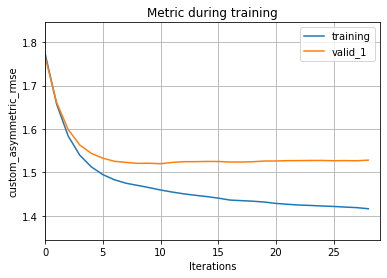

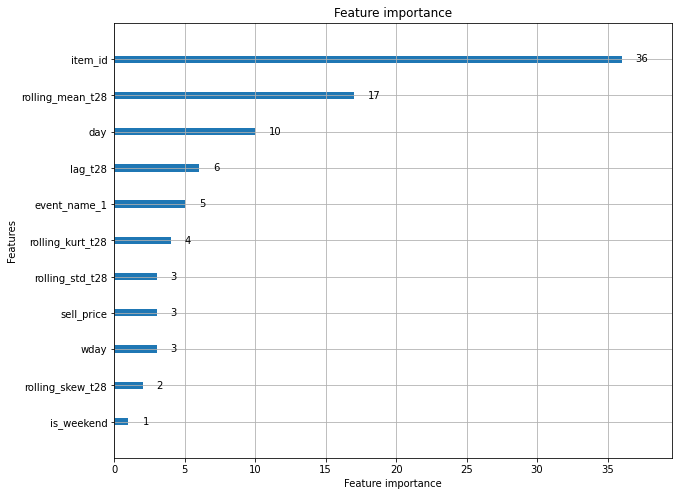

In [11]:
for cat in x_pred.cat_id.drop_duplicates():
    print('\n ***** Computation for cat_id ', cat, '*****')
    
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    evals = pickle.load(open(f'{models_path}evals_result_cat_id_{cat}_{prefix}.pkl', 'rb'))

    ax = lgb.plot_metric(evals)
    plt.show()
    
    ax = lgb.plot_importance(mod, figsize=(10,8))
    plt.show()
    


# Compute RMSSE and WRMSSE on Validation Data

In [12]:
# compute forecasts, error and map it to df_merged to get ids

# create validation set containing all categories
df_last_28d = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
df_last_28d['y_true'] = df_merged.loc[df_merged['data_type'] ==
                          'train'].loc[df_merged['date'] > '2016-03-27']['sale'].copy()

for cat in df_last_28d.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    df_last_28d.loc[df_last_28d.cat_id == cat,'y_pred'] = mod.predict(df_last_28d.loc[df_last_28d.cat_id == cat][features])
    
df_last_28d['error'] = (df_last_28d.y_true - df_last_28d.y_pred)
df_last_28d = df_last_28d.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_last_28d.head(10)

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_true,y_pred,error,id
0,0,0,0,0,0,2016,3,28,0,3,...,3.823490,0.533333,1.166585,0.0,0.0,0.0,0.0,0.464531,-0.464531,HOBBIES_1_001_TX_2_validation
1,0,0,0,0,0,2016,3,29,0,4,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,0.0,0.404706,-0.404706,HOBBIES_1_001_TX_2_validation
2,0,0,0,0,0,2016,3,30,0,5,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,0.0,0.404706,-0.404706,HOBBIES_1_001_TX_2_validation
3,0,0,0,0,0,2016,3,31,0,6,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,1.0,0.404706,0.595294,HOBBIES_1_001_TX_2_validation
4,0,0,0,0,0,2016,4,1,0,7,...,4.239248,0.466667,1.136642,0.0,0.0,0.0,0.0,0.404706,-0.404706,HOBBIES_1_001_TX_2_validation
5,0,0,0,0,0,2016,4,2,1,1,...,4.344295,0.433333,1.135124,0.0,0.0,0.0,2.0,0.404706,1.595294,HOBBIES_1_001_TX_2_validation
6,0,0,0,0,0,2016,4,3,1,2,...,1.111663,0.266667,0.449776,0.0,0.0,0.0,0.0,0.256927,-0.256927,HOBBIES_1_001_TX_2_validation
7,0,0,0,0,0,2016,4,4,0,3,...,1.111663,0.266667,0.449776,0.0,0.0,0.0,0.0,0.256927,-0.256927,HOBBIES_1_001_TX_2_validation
8,0,0,0,0,0,2016,4,5,0,4,...,1.111663,0.266667,0.449776,0.0,0.0,0.0,1.0,0.256927,0.743073,HOBBIES_1_001_TX_2_validation
9,0,0,0,0,0,2016,4,6,0,5,...,1.328338,0.233333,0.430183,0.0,0.0,0.0,0.0,0.206976,-0.206976,HOBBIES_1_001_TX_2_validation


In [13]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_last_28d.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [14]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [15]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.01162


In [16]:
# show RMSSE and corresponding weights
rmsse_df.sort_values(by='RMSSE', ascending=False).head(20)

,RMSSE,id,weights,w_times_RMSSE
522,2.135099,HOBBIES_2_107_TX_2_validation,0.000005,0.000010
176,1.899333,HOBBIES_1_181_TX_2_validation,0.000004,0.000008
556,1.829068,HOBBIES_2_141_TX_2_validation,0.000002,0.000003
197,1.815840,HOBBIES_1_204_TX_2_validation,0.000280,0.000509
392,1.473853,HOBBIES_1_401_TX_2_validation,0.000006,0.000009
180,1.466884,HOBBIES_1_186_TX_2_validation,0.000051,0.000075
226,1.465015,HOBBIES_1_234_TX_2_validation,0.000008,0.000012
251,1.455510,HOBBIES_1_259_TX_2_validation,0.000008,0.000011
447,1.442584,HOBBIES_2_032_TX_2_validation,0.000010,0.000014
101,1.422860,HOBBIES_1_106_TX_2_validation,0.000008,0.000011


In [17]:
# analyse time series (manually)
rel_id = 'HOBBIES_2_107_TX_2_validation'
df_last_28d.loc[df_last_28d.id == rel_id][[
    'id',
    'month',
    'day',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'is_weekend',
    'wday',
    'sell_price',
    'y_pred',
    'y_true',
    'error',
]]

,id,month,day,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
14616,HOBBIES_2_107_TX_2_validation,3,28,13,1,0,0,0,3,0.5,0.288356,1.0,0.711644
14617,HOBBIES_2_107_TX_2_validation,3,29,13,1,0,0,0,4,0.5,0.288356,0.0,-0.288356
14618,HOBBIES_2_107_TX_2_validation,3,30,13,1,0,0,0,5,0.5,0.351401,14.0,13.648599
14619,HOBBIES_2_107_TX_2_validation,3,31,13,1,0,0,0,6,0.5,0.351401,0.0,-0.351401
14620,HOBBIES_2_107_TX_2_validation,4,1,13,1,0,0,0,7,0.5,0.288356,0.0,-0.288356
14621,HOBBIES_2_107_TX_2_validation,4,2,13,1,0,0,1,1,0.5,0.288356,1.0,0.711644
14622,HOBBIES_2_107_TX_2_validation,4,3,13,1,0,0,1,2,0.5,0.288356,1.0,0.711644
14623,HOBBIES_2_107_TX_2_validation,4,4,13,1,0,0,0,3,0.5,0.288356,1.0,0.711644
14624,HOBBIES_2_107_TX_2_validation,4,5,13,1,0,0,0,4,0.5,0.256927,1.0,0.743073
14625,HOBBIES_2_107_TX_2_validation,4,6,13,1,0,0,0,5,0.5,0.206976,0.0,-0.206976


# Error for different Predicting Intervals

In [18]:
x_val_pred = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features].copy()
y_val_pred = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']


x_val_pred['y_pred'] = np.nan


for cat in x_val_pred.cat_id.drop_duplicates():
    mod = lgb.Booster(model_file=f'{models_path}gbm_cat_id_{cat}_{prefix}.txt')
    x_val_pred.loc[x_val_pred.cat_id == cat,'y_pred'] = mod.predict(x_val_pred.loc[x_val_pred.cat_id == cat][features])


In [19]:
x_val_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
89270,0,0,0,0,0,2016,3,28,0,3,...,8.26,0.0,19.222143,3.823490,0.533333,1.166585,0.0,0.0,0.0,0.464531
89271,1,0,0,0,0,2016,3,28,0,3,...,3.97,0.0,17.401083,4.280921,0.100000,0.402578,0.0,0.0,0.0,0.206976
89272,2,0,0,0,0,2016,3,28,0,3,...,2.97,0.0,11.183432,3.659999,0.066667,0.253708,0.0,0.0,0.0,0.206976
89273,3,0,0,0,0,2016,3,28,0,3,...,4.64,0.0,1.346979,1.479220,1.233333,1.633345,0.0,0.0,0.0,1.201783
89274,4,0,0,0,0,2016,3,28,0,3,...,2.73,0.0,0.542877,1.329992,0.400000,0.621455,0.0,0.0,0.0,0.674895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105085,560,1,0,0,0,2016,4,24,1,2,...,2.88,0.0,2.301931,1.638289,0.366667,0.668675,0.0,0.0,0.0,0.351401
105086,561,1,0,0,0,2016,4,24,1,2,...,1.97,0.0,0.889431,1.215798,0.366667,0.556053,0.0,0.0,0.0,0.351401
105087,562,1,0,0,0,2016,4,24,1,2,...,0.97,0.0,6.228641,2.014144,0.600000,0.932183,0.0,0.0,0.0,0.464531
105088,563,1,0,0,0,2016,4,24,1,2,...,0.88,0.0,17.401083,4.280921,0.100000,0.402578,0.0,0.0,0.0,0.206976


In [20]:
id_mapping_table = df_merged[['id', 'date','item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
id_mapping_table

,id,date,item_id,year,month,day,store_id
0,HOBBIES_1_001_TX_2_validation,2015-10-22,0,2015,10,22,0
1,HOBBIES_1_002_TX_2_validation,2015-10-22,1,2015,10,22,0
2,HOBBIES_1_003_TX_2_validation,2015-10-22,2,2015,10,22,0
3,HOBBIES_1_004_TX_2_validation,2015-10-22,3,2015,10,22,0
4,HOBBIES_1_005_TX_2_validation,2015-10-22,4,2015,10,22,0
...,...,...,...,...,...,...,...
120905,HOBBIES_2_145_TX_2_validation,2016-05-22,560,2016,5,22,0
120906,HOBBIES_2_146_TX_2_validation,2016-05-22,561,2016,5,22,0
120907,HOBBIES_2_147_TX_2_validation,2016-05-22,562,2016,5,22,0
120908,HOBBIES_2_148_TX_2_validation,2016-05-22,563,2016,5,22,0


In [21]:
df_tmp = x_val_pred.copy()
df_tmp = df_tmp.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'])
df_tmp['y_true'] = y_val_pred.values
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred,id,date,y_true,error
0,0,0,0,0,0,2016,3,28,0,3,...,0.533333,1.166585,0.0,0.0,0.0,0.464531,HOBBIES_1_001_TX_2_validation,2016-03-28,0.0,-0.464531
1,1,0,0,0,0,2016,3,28,0,3,...,0.100000,0.402578,0.0,0.0,0.0,0.206976,HOBBIES_1_002_TX_2_validation,2016-03-28,0.0,-0.206976
2,2,0,0,0,0,2016,3,28,0,3,...,0.066667,0.253708,0.0,0.0,0.0,0.206976,HOBBIES_1_003_TX_2_validation,2016-03-28,0.0,-0.206976
3,3,0,0,0,0,2016,3,28,0,3,...,1.233333,1.633345,0.0,0.0,0.0,1.201783,HOBBIES_1_004_TX_2_validation,2016-03-28,0.0,-1.201783
4,4,0,0,0,0,2016,3,28,0,3,...,0.400000,0.621455,0.0,0.0,0.0,0.674895,HOBBIES_1_005_TX_2_validation,2016-03-28,0.0,-0.674895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15815,560,1,0,0,0,2016,4,24,1,2,...,0.366667,0.668675,0.0,0.0,0.0,0.351401,HOBBIES_2_145_TX_2_validation,2016-04-24,0.0,-0.351401
15816,561,1,0,0,0,2016,4,24,1,2,...,0.366667,0.556053,0.0,0.0,0.0,0.351401,HOBBIES_2_146_TX_2_validation,2016-04-24,2.0,1.648599
15817,562,1,0,0,0,2016,4,24,1,2,...,0.600000,0.932183,0.0,0.0,0.0,0.464531,HOBBIES_2_147_TX_2_validation,2016-04-24,0.0,-0.464531
15818,563,1,0,0,0,2016,4,24,1,2,...,0.100000,0.402578,0.0,0.0,0.0,0.206976,HOBBIES_2_148_TX_2_validation,2016-04-24,0.0,-0.206976


In [22]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.00810
WRMSSE of (2016, 3, 29) = 0.00755
WRMSSE of (2016, 3, 30) = 0.00857
WRMSSE of (2016, 3, 31) = 0.00791
WRMSSE of (2016, 4, 1) = 0.00953
WRMSSE of (2016, 4, 2) = 0.01058
WRMSSE of (2016, 4, 3) = 0.00850
WRMSSE of (2016, 4, 4) = 0.00912
WRMSSE of (2016, 4, 5) = 0.00848
WRMSSE of (2016, 4, 6) = 0.00730
WRMSSE of (2016, 4, 7) = 0.00888
WRMSSE of (2016, 4, 8) = 0.00818
WRMSSE of (2016, 4, 9) = 0.01049
WRMSSE of (2016, 4, 10) = 0.01065
WRMSSE of (2016, 4, 11) = 0.00873
WRMSSE of (2016, 4, 12) = 0.01029
WRMSSE of (2016, 4, 13) = 0.00874
WRMSSE of (2016, 4, 14) = 0.00756
WRMSSE of (2016, 4, 15) = 0.00902
WRMSSE of (2016, 4, 16) = 0.01016
WRMSSE of (2016, 4, 17) = 0.01123
WRMSSE of (2016, 4, 18) = 0.00731
WRMSSE of (2016, 4, 19) = 0.01002
WRMSSE of (2016, 4, 20) = 0.01114
WRMSSE of (2016, 4, 21) = 0.01058
WRMSSE of (2016, 4, 22) = 0.00809
WRMSSE of (2016, 4, 23) = 0.01091
WRMSSE of (2016, 4, 24) = 0.00911


# Printout Forecasts

In [23]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t28,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
105090,0,0,0,0,0,2016,4,25,0,3,...,8.26,0.0,8.085505,2.942952,0.266667,0.691492,0.0,0.0,0.0,0.256927
105091,1,0,0,0,0,2016,4,25,0,3,...,3.97,0.0,28.000000,5.477226,0.033333,0.182574,0.0,0.0,0.0,0.206976
105092,2,0,0,0,0,2016,4,25,0,3,...,2.97,0.0,28.000000,5.477226,0.033333,0.182574,0.0,0.0,0.0,0.206976
105093,3,0,0,0,0,2016,4,25,0,3,...,4.64,0.0,0.815230,1.051023,1.100000,1.322224,0.0,0.0,0.0,1.201783
105094,4,0,0,0,0,2016,4,25,0,3,...,2.73,0.0,6.833795,2.557249,0.600000,1.132589,0.0,0.0,0.0,0.734720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120905,560,1,0,0,0,2016,5,22,1,2,...,2.88,0.0,11.497869,3.494974,0.133333,0.434172,0.0,0.0,0.0,0.206976
120906,561,1,0,0,0,2016,5,22,1,2,...,1.97,2.0,3.233676,2.147972,0.266667,0.583292,0.0,0.0,0.0,0.256927
120907,562,1,0,0,0,2016,5,22,1,2,...,0.97,0.0,6.534278,2.387013,0.700000,1.118805,0.0,0.0,0.0,0.603699
120908,563,1,0,0,0,2016,5,22,1,2,...,0.88,0.0,NaN,NaN,0.000000,0.000000,0.0,0.0,0.0,0.206976


In [24]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [25]:
id_mapping_table

,id,item_id,year,month,day,store_id
0,HOBBIES_1_001_TX_2_validation,0,2015,10,22,0
1,HOBBIES_1_002_TX_2_validation,1,2015,10,22,0
2,HOBBIES_1_003_TX_2_validation,2,2015,10,22,0
3,HOBBIES_1_004_TX_2_validation,3,2015,10,22,0
4,HOBBIES_1_005_TX_2_validation,4,2015,10,22,0
...,...,...,...,...,...,...
120905,HOBBIES_2_145_TX_2_validation,560,2016,5,22,0
120906,HOBBIES_2_146_TX_2_validation,561,2016,5,22,0
120907,HOBBIES_2_147_TX_2_validation,562,2016,5,22,0
120908,HOBBIES_2_148_TX_2_validation,563,2016,5,22,0


In [26]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [27]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.256927,0.256927,0.256927,0.288356,0.288356,0.351401,0.351401,0.351401,0.351401,...,0.351401,0.351401,0.351401,0.351401,0.351401,0.404706,0.404706,0.404706,0.288356,0.288356
1,HOBBIES_1_002_TX_2_validation,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976
2,HOBBIES_1_003_TX_2_validation,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976
3,HOBBIES_1_004_TX_2_validation,1.201783,0.979875,0.979875,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,...,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783
4,HOBBIES_1_005_TX_2_validation,0.734720,0.679983,0.679983,0.734720,0.734720,0.679983,0.679983,0.679983,0.734720,...,0.734720,0.734720,0.734720,0.734720,0.734720,0.734720,0.558545,0.558545,0.621590,0.558545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,HOBBIES_2_145_TX_2_validation,0.351401,0.288356,0.288356,0.288356,0.288356,0.288356,0.288356,0.288356,0.288356,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976
561,HOBBIES_2_146_TX_2_validation,0.351401,0.288356,0.288356,0.351401,0.351401,0.351401,0.404706,0.404706,0.351401,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.256927
562,HOBBIES_2_147_TX_2_validation,0.464531,0.464531,0.464531,0.464531,0.514610,0.514610,0.603699,0.514610,0.603699,...,0.668531,0.668531,0.668531,0.668531,0.668531,0.603699,0.603699,0.668531,0.668531,0.603699
563,HOBBIES_2_148_TX_2_validation,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976


# Increase Predictions for Food Items as they are underestimated

In [28]:

df = df_last_28d.copy()
df['error'] = (df.y_true - df.y_pred)

# compute RMSSE and store it in dict
rmsse_dict = {}



print('computing RMSSE')
for name, group in df.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]

    
print('converting dict to dataframe')
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

print('add weights to df and compute weights multiplied by RMSSE')
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

print('sort values by their impact')
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)



print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))


computing RMSSE
converting dict to dataframe
add weights to df and compute weights multiplied by RMSSE
sort values by their impact
WRMSSE = 0.01162


In [29]:
rmsse_df

,RMSSE,id,weights,w_times_RMSSE
522,2.135099,HOBBIES_2_107_TX_2_validation,0.000005,0.000010
176,1.899333,HOBBIES_1_181_TX_2_validation,0.000004,0.000008
556,1.829068,HOBBIES_2_141_TX_2_validation,0.000002,0.000003
197,1.815840,HOBBIES_1_204_TX_2_validation,0.000280,0.000509
392,1.473853,HOBBIES_1_401_TX_2_validation,0.000006,0.000009
...,...,...,...,...
472,0.185809,HOBBIES_2_057_TX_2_validation,0.000000,0.000000
431,0.184711,HOBBIES_2_016_TX_2_validation,0.000000,0.000000
326,0.114141,HOBBIES_1_335_TX_2_validation,0.000000,0.000000
228,0.110987,HOBBIES_1_236_TX_2_validation,0.000000,0.000000


In [30]:
# compute pertentage error of forecasts and corresponding ids
factors = []
for i in rmsse_df.id:
    factors.append(df_last_28d.loc[df_last_28d.id == i].y_pred.mean() / df_last_28d.loc[df_last_28d.id == i].y_true.mean())

labels_0 = rmsse_df.id[:50].values
labels_1 = rmsse_df.id[50:100].values
labels_2 = rmsse_df.id[100:200].values
labels_3 = rmsse_df.id[200:300].values


c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [31]:
# get list of food elements
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

In [32]:
# print fraction of predicted values compared to target
print(np.mean(factors[0:50]))
print(np.mean(factors[50:100]))
print(np.mean(factors[100:200]))
print(np.mean(factors[200:300]))
print(np.mean(factors[300:400]))
print(np.mean(factors[400:500]))
print(np.mean(factors[500:]))

0.6903344204322317
0.8440658509301189
0.9411103650888565
inf
inf
inf
inf


In [33]:
submission_df.loc[submission_df.id.isin(labels_0),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_0),
                                            f_list] * 1.3

submission_df.loc[submission_df.id.isin(labels_1),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_1),
                                            f_list] * 1.25

submission_df.loc[submission_df.id.isin(labels_2),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_2),
                                            f_list] * 1.08

submission_df.loc[submission_df.id.isin(labels_3),
                  f_list] = submission_df.loc[submission_df.id.isin(labels_3),
                                            f_list] * 0.96


submission_df



,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.256927,0.256927,0.256927,0.288356,0.288356,0.351401,0.351401,0.351401,0.351401,...,0.351401,0.351401,0.351401,0.351401,0.351401,0.404706,0.404706,0.404706,0.288356,0.288356
1,HOBBIES_1_002_TX_2_validation,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,...,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534,0.223534
2,HOBBIES_1_003_TX_2_validation,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,...,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697
3,HOBBIES_1_004_TX_2_validation,1.201783,0.979875,0.979875,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,...,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783,1.201783
4,HOBBIES_1_005_TX_2_validation,0.734720,0.679983,0.679983,0.734720,0.734720,0.679983,0.679983,0.679983,0.734720,...,0.734720,0.734720,0.734720,0.734720,0.734720,0.734720,0.558545,0.558545,0.621590,0.558545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,HOBBIES_2_145_TX_2_validation,0.351401,0.288356,0.288356,0.288356,0.288356,0.288356,0.288356,0.288356,0.288356,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976
561,HOBBIES_2_146_TX_2_validation,0.337345,0.276822,0.276822,0.337345,0.337345,0.337345,0.388518,0.388518,0.337345,...,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.198697,0.246650
562,HOBBIES_2_147_TX_2_validation,0.501693,0.501693,0.501693,0.501693,0.555779,0.555779,0.651995,0.555779,0.651995,...,0.722013,0.722013,0.722013,0.722013,0.722013,0.651995,0.651995,0.722013,0.722013,0.651995
563,HOBBIES_2_148_TX_2_validation,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,...,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976,0.206976


# Submit to Kaggle 

In [34]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation',
                          value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)